In [1]:
!pip install opencv-python mediapipe numpy pandas scikit-learn matplotlib tensorflow

INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/51.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/51.0 MB 2.8 MB/s eta 0:00:19
    --------------------------------------- 1.0/51.0 MB 3.0 MB/s eta 0:00:17
   - -------------------------------------- 1.6/51.0 MB 2.8 MB/s eta 0:00:18
   - -------------------------------------- 2.1/51.0 MB 2.8 MB/s eta 0:00:18
   -- ------------------------------------- 2.6/51.0 MB 2.6 MB/s eta 0:00:19
   -- ------------------------------------- 3.1/51.0 MB 2.7 MB/s eta 0:00:18
   -- ------------------------------------- 3.4/51.0 MB 2.4 MB/s eta 0:00:20
   --- ------------------------------------ 3.9/51.0 MB 2.4 MB/s eta 0:00:20
   --- --

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.37.1 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.
streamlit 1.37.1 requires rich<14,>=10.14.0, but you have rich 14.1.0 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import os

In [3]:
def normalize_landmarks(landmarks):
    """
    landmarks: list of (x,y) from mediapipe
    returns: flattened normalized vector (42 values)
    """
    pts = np.array(landmarks, dtype=np.float32)  

    
    origin = pts[0].copy()
    pts -= origin

   
    max_dist = np.linalg.norm(pts, axis=1).max()
    if max_dist > 1e-6:
        pts /= max_dist

    
    ref = pts[9]
    angle = np.arctan2(ref[1], ref[0])
    cos, sin = np.cos(-angle), np.sin(-angle)
    R = np.array([[cos, -sin], [sin, cos]], dtype=np.float32)
    pts = pts.dot(R.T)

    return pts.flatten()


In [4]:
mp_hands = mp.solutions.hands

dataset_dir = r"D:\Gesture Image Data"  
out_csv = "features.csv"

rows = []
with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5) as hands:
    for class_name in sorted(os.listdir(dataset_dir)):
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        files = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg",".jpeg",".png"))]
        print(f"[{class_name}] {len(files)} images")
        for fn in files:
            full_path = os.path.join(class_path, fn)
            img = cv2.imread(full_path)
            if img is None:
                continue
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = hands.process(img_rgb)
            if not results.multi_hand_landmarks:
                continue
            lm = [(p.x, p.y) for p in results.multi_hand_landmarks[0].landmark]
            feats = normalize_landmarks(lm)
            rows.append([class_name] + feats.tolist())

df = pd.DataFrame(rows, columns=["label"]+[f"x{i}" for i in range(21)]+[f"y{i}" for i in range(21)])
df.to_csv(out_csv, index=False)
print("Saved", out_csv, "with", len(df), "samples")


[0] 70 images
[1] 70 images
[2] 70 images
[3] 70 images
[4] 70 images
[5] 70 images
[6] 70 images
[7] 70 images
[8] 70 images
[9] 70 images
[A] 112 images
[B] 112 images
[C] 112 images
[D] 112 images
[E] 112 images
[F] 112 images
[G] 112 images
[H] 112 images
[I] 116 images
[J] 108 images
[K] 112 images
[L] 112 images
[M] 112 images
[N] 112 images
[O] 112 images
[P] 112 images
[Q] 112 images
[R] 112 images
[S] 112 images
[T] 107 images
[U] 112 images
[V] 112 images
[W] 112 images
[X] 112 images
[Y] 112 images
[Z] 112 images
Saved features.csv with 2641 samples


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import joblib


df = pd.read_csv("features.csv")

print("Shape:", df.shape)
print("First few rows:")
print(df.head())


X = df.drop("label", axis=1).values  
y = df["label"].values               


encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print("Classes:", encoder.classes_)


X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print("Train size:", len(X_train), "Test size:", len(X_test))


rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print("\n RandomForest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf, target_names=encoder.classes_))


joblib.dump(rf_model, "sign_rf_model.pkl")
print("✅ RandomForest model saved!")


knn_model = KNeighborsClassifier(n_neighbors=5)  
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)
print("\n KNN Results")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn, target_names=encoder.classes_))


joblib.dump(knn_model, "sign_knn_model.pkl")
print("✅ KNN model saved!")


joblib.dump(encoder, "label_encoder.pkl")
print("✅ Label encoder saved!")



Shape: (2641, 43)
First few rows:
  label   x0   x1        x2        x3        x4        x5        x6        x7  \
0     0  0.0  0.0  0.024800  0.074626  0.116079  0.175407  0.165378  0.323196   
1     0  0.0  0.0  0.153534  0.163966  0.292220  0.299196  0.330183  0.504570   
2     0  0.0  0.0 -0.041443  0.075369 -0.040896  0.125645 -0.072821  0.180364   
3     0  0.0  0.0  0.070443  0.259280  0.265973  0.438363  0.428417  0.597116   
4     0  0.0  0.0  0.147687  0.301965  0.335176  0.424568  0.449820  0.555618   

         x8  ...       y11       y12       y13       y14       y15       y16  \
0  0.174111  ...  0.489874  0.871793  0.673746  0.126895  0.651519  0.501924   
1  0.313030  ...  0.449510  0.884546  0.502600  0.068987  0.553705  0.416290   
2 -0.169409  ...  0.547519  0.836793  0.760484  0.110117  0.773786  0.448054   
3  0.647339  ...  0.694458  0.525569  0.597347 -0.112096  0.827006  0.110278   
4  0.540692  ...  0.620516  0.692774  0.486571  0.136202  0.707948  0.404817   

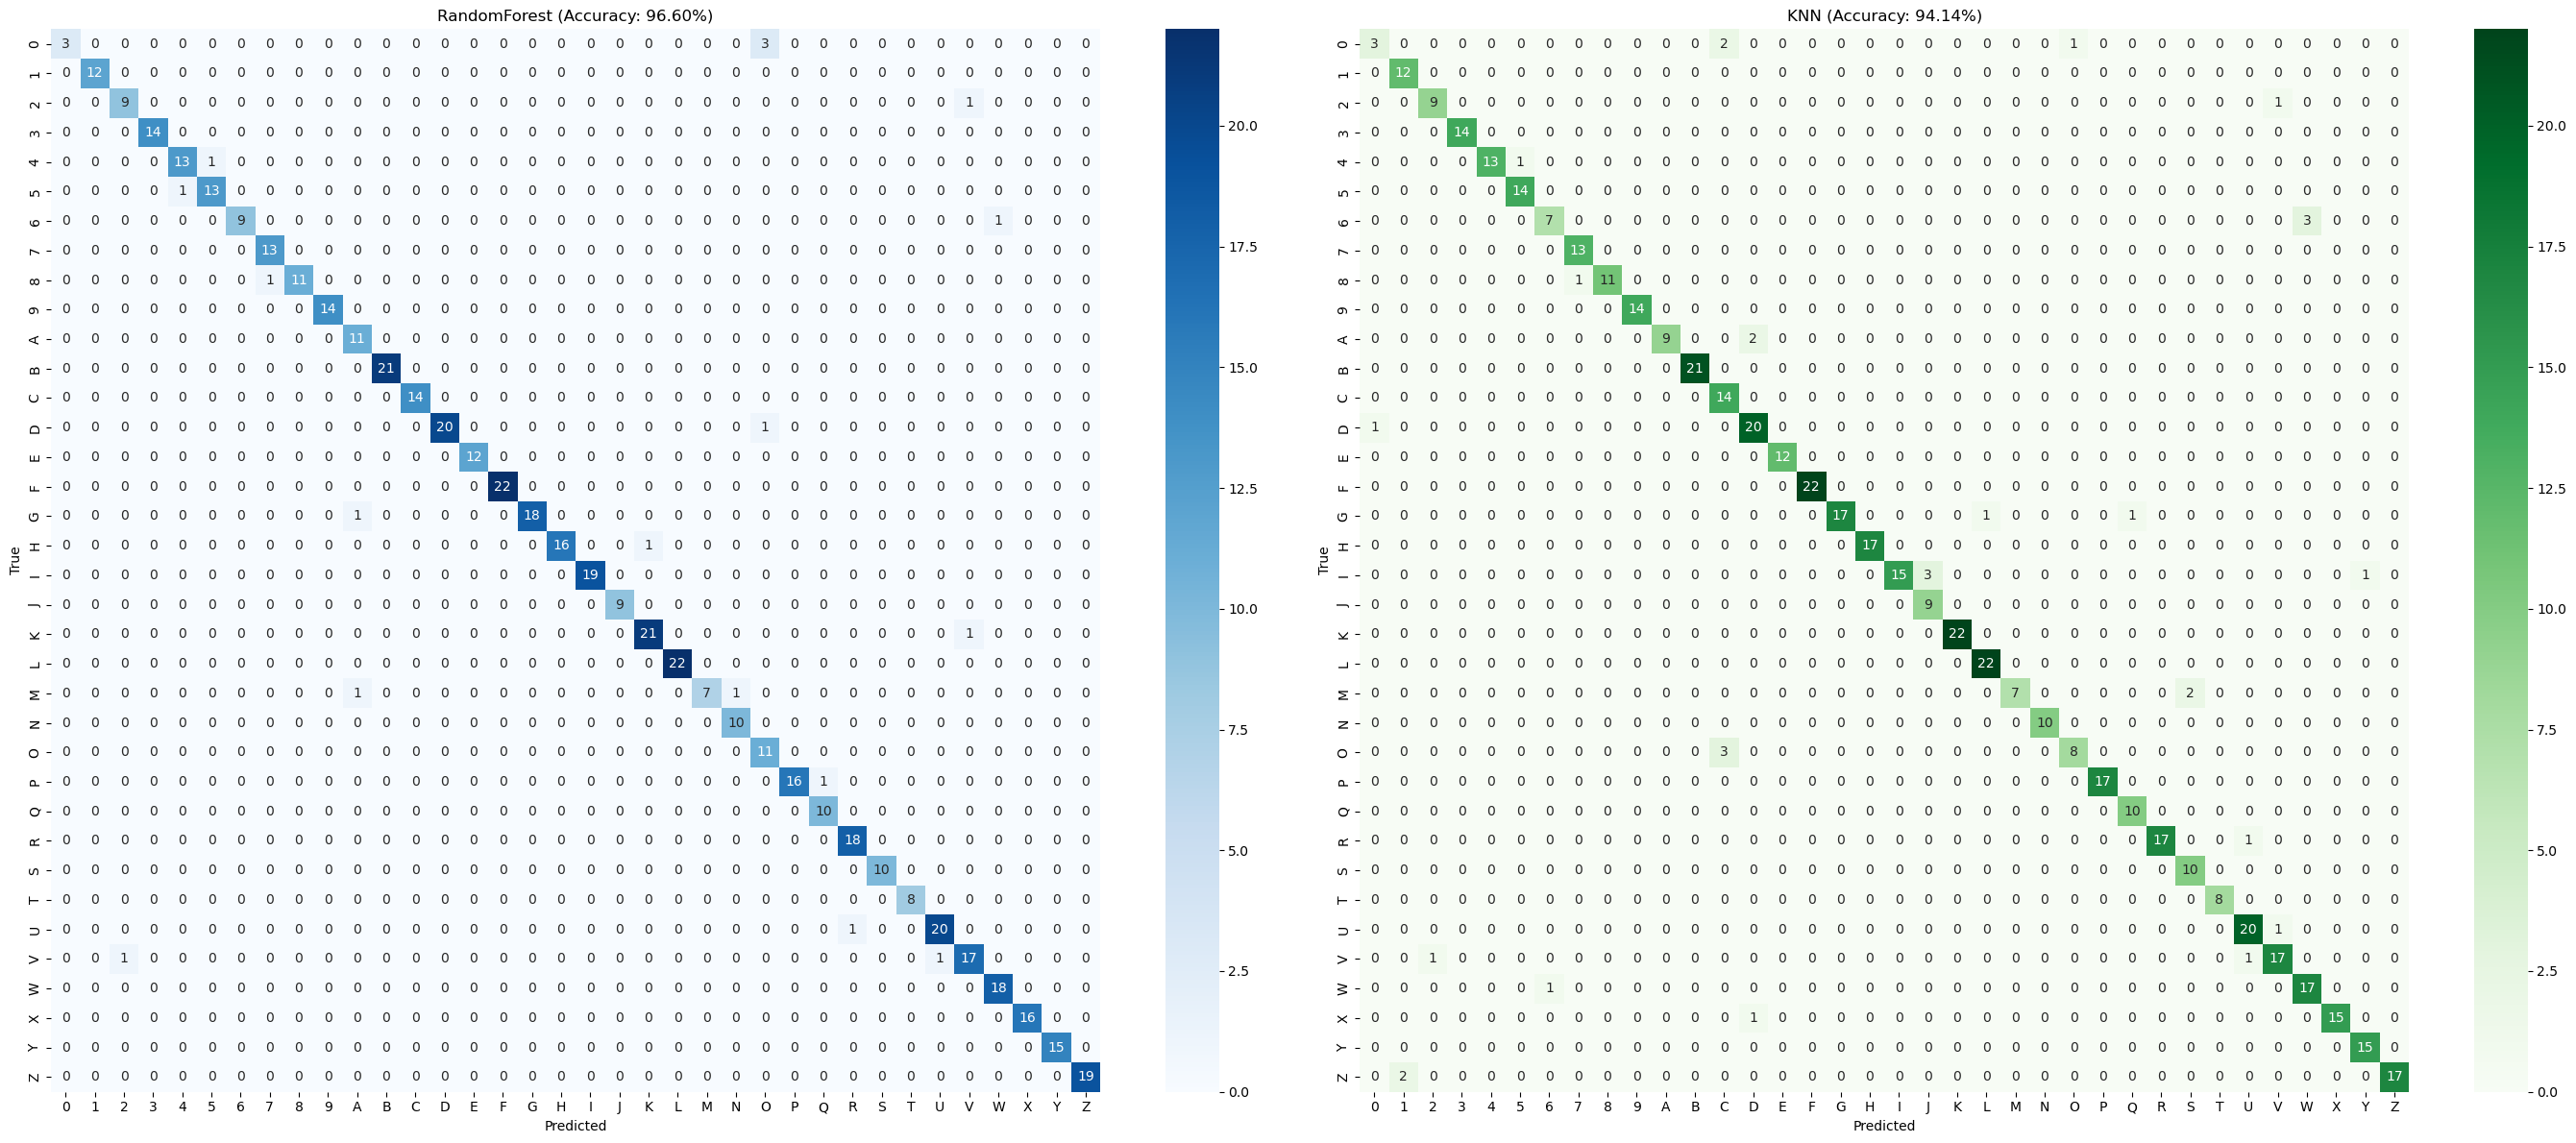

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_knn = confusion_matrix(y_test, y_pred_knn)

acc_rf = accuracy_score(y_test, y_pred_rf)
acc_knn = accuracy_score(y_test, y_pred_knn)

fig, axes = plt.subplots(1, 2, figsize=(28, 12))


sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_,
            ax=axes[0])
axes[0].set_title(f"RandomForest (Accuracy: {acc_rf:.2%})")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")


sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Greens",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_,
            ax=axes[1])
axes[1].set_title(f"KNN (Accuracy: {acc_knn:.2%})")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()


In [8]:
import cv2
import mediapipe as mp
import numpy as np
import joblib
from collections import deque, Counter


model = joblib.load("sign_rf_model.pkl")   
encoder = joblib.load("label_encoder.pkl")


mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils



In [9]:
def normalize_landmarks(landmarks):
    pts = np.array(landmarks, dtype=np.float32)  

    
    origin = pts[0].copy()
    pts -= origin

    
    max_dist = np.linalg.norm(pts, axis=1).max()
    if max_dist > 1e-6:
        pts /= max_dist

    
    ref = pts[9]
    angle = np.arctan2(ref[1], ref[0])
    cos, sin = np.cos(-angle), np.sin(-angle)
    R = np.array([[cos, -sin], [sin, cos]], dtype=np.float32)
    pts = pts.dot(R.T)

    return pts.flatten()


In [10]:
from collections import deque, Counter


prediction_window = deque(maxlen=10)  

cap = cv2.VideoCapture(0)

with mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.7
) as hands:

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)  # mirror view
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
               
                lm = [(p.x, p.y) for p in hand_landmarks.landmark]

               
                feats = normalize_landmarks(lm).reshape(1, -1)

               
                pred = model.predict(feats)[0]
                label = encoder.inverse_transform([pred])[0]

               
                prediction_window.append(label)
                stable_label = Counter(prediction_window).most_common(1)[0][0]

                
                mp_drawing.draw_landmarks(
                    frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

                
                cv2.putText(frame, f"Predicted: {stable_label}",
                            (10, 50), cv2.FONT_HERSHEY_SIMPLEX,
                            1, (0, 255, 0), 2)

        cv2.imshow("Sign Language Recognition", frame)

       
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()